In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Define data loaders
from torch.utils.data import DataLoader, random_split, Subset
import copy
import pickle
# torch.backends.nnpack.enabled = False

# Define preprocessing transformations
import os

In [31]:
# Define the root directory for data
data_root = './data'

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])

# Check if MNIST dataset is already downloaded, if not, download it
if not os.path.exists(os.path.join(data_root, 'MNIST')):
    mnist_trainset = torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
    mnist_testset = torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform=transform)
else:
    mnist_trainset = torchvision.datasets.MNIST(root=data_root, train=True, download=False, transform=transform)
    mnist_testset = torchvision.datasets.MNIST(root=data_root, train=False, download=False, transform=transform)

# Check if CIFAR-10 dataset is already downloaded, if not, download it
if not os.path.exists(os.path.join(data_root, 'CIFAR10')):
    cifar_trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
    cifar_testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)
else:
    cifar_trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform)
    cifar_testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [32]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 1 input channel, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)  # 32 input channels, 32 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)  # 32 input channels, 64 output channels, 3x3 kernel
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)  # 64 input channels, 64 output channels, 3x3 kernel
        
        # Define max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling with stride 2
        
        # Define global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        
        # Define fully connected layer
        self.fc = nn.Linear(64, 10)  # 64 input features, 10 output classes

    def forward(self, x):
        # Apply convolution and ReLU activation
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        # Apply max pooling
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        # Apply global average pooling
        x = self.global_pool(x)
        # Flatten for fully connected layer
        x = x.view(-1, 64)
        # Fully connected layer
        x = self.fc(x)
        return x
	    
    def log_prob(self, x):
        # Compute the logits using the forward pass
        logits = self.forward(x)
        # Compute the log probability using softmax and log
        log_probabilities = F.log_softmax(logits, dim=1) # torch.nn.functional
        return log_probabilities

The paper uses the 50-layer resnet as given in table 1 [here](https://www.semanticscholar.org/reader/2c03df8b48bf3fa39054345bafabfeff15bfd11d)<br>
[Indepth look at Resnet 50](https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f)<br>
ResNet-50 has an architecture based on resnet-34, but with one important difference. The 50-layer ResNet uses a bottleneck design for the building block. A bottleneck residual block uses 1×1 convolutions, known as a “bottleneck”, which reduces the number of parameters and matrix multiplications. This enables much faster training of each layer. It uses a stack of three layers rather than two layers.<br>
The 50-layer ResNet architecture includes the following elements:<br>
A 7×7 kernel convolution alongside 64 other kernels with a 2-sized stride.<br>
A max pooling layer with a 2-sized stride.<br>
9 more layers—3×3,64 kernel convolution, another with 1×1,64 kernels, and a third with 1×1,256 kernels. These 3 layers are repeated 3 times. <br>
12 more layers with 1×1,128 kernels, 3×3,128 kernels, and 1×1,512 kernels, iterated 4 times.<br>
18 more layers with 1×1,256 cores, and 2 cores 3×3,256 and 1×1,1024, iterated 6 times.<br>
9 more layers with 1×1,512 cores, 3×3,512 cores, and 1×1,2048 cores iterated 3 times.<br>
(up to this point the network has 50 layers)<br>
Average pooling, followed by a fully connected layer with 1000 nodes, using the softmax activation function.<br>
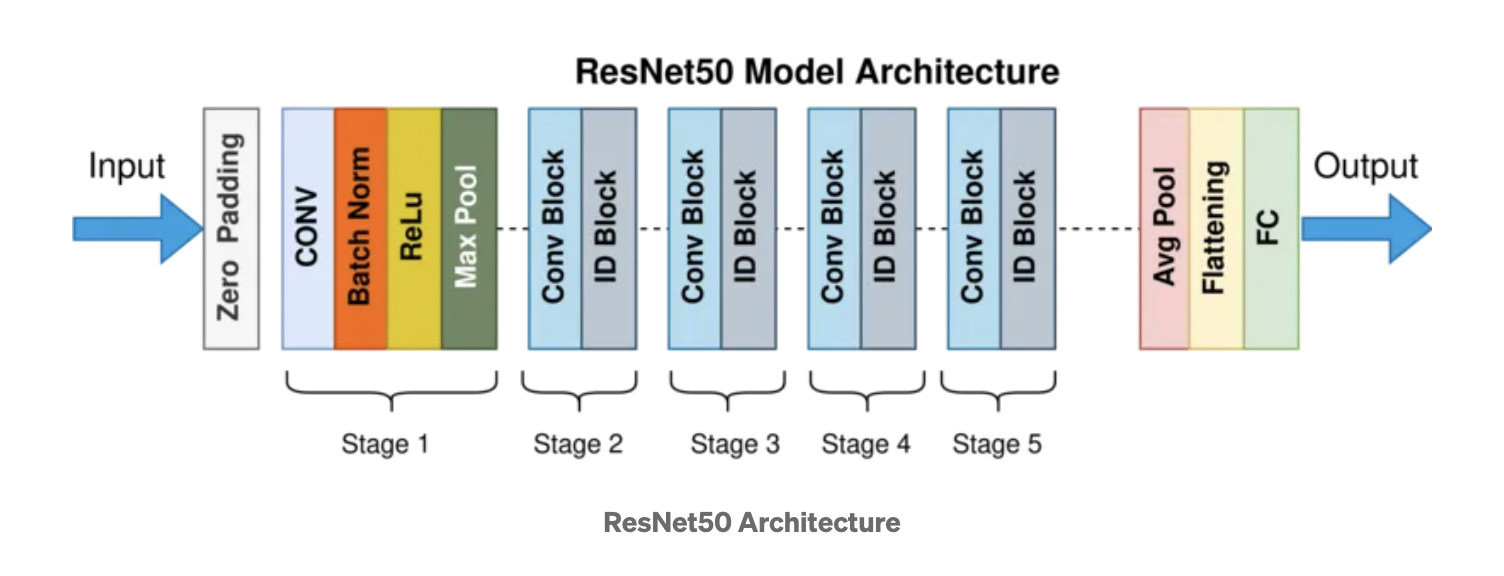


In [33]:
# ResNet50 architecture for CIFAR-10
class CIFAR_ResNet(nn.Module):
    def __init__(self):
        super(CIFAR_ResNet, self).__init__()
        self.resnet50 = resnet50(num_classes=10)

    def forward(self, x):
        return self.resnet50(x)

In [34]:
# Initialize models and optimizer
mnist_model = MNIST_CNN()
cifar_model = CIFAR_ResNet()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
cifar_optimizer = optim.Adam(cifar_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss() # multiclassification

# Define the size of the validation set (10% of the training set)
validation_size_mnist = int(0.1 * len(mnist_trainset))
# Split the training set into training and validation sets
mnist_trainset, mnist_valset = random_split(mnist_trainset, [len(mnist_trainset) - validation_size_mnist, validation_size_mnist])

# Define data loaders for training, validation, and testing
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_valloader = DataLoader(mnist_valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

# Define the size of the validation set (10% of the training set)
validation_size_cifar = int(0.1 * len(cifar_trainset))

# Split the training set into training and validation sets
cifar_trainset, cifar_valset = random_split(cifar_trainset, [len(cifar_trainset) - validation_size_cifar, validation_size_cifar])

# Define data loaders for training, validation, and testing
cifar_trainloader = DataLoader(cifar_trainset, batch_size=64, shuffle=True)
cifar_valloader = DataLoader(cifar_valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
cifar_testloader = DataLoader(cifar_testset, batch_size=64, shuffle=False)

In [35]:
def train_with_early_stopping(trainloader, valloader, testloader, model, optimizer, criterion, patience=5, noised= False):
    best_val_accuracy = 0
    no_improvement_counter = 0

    for epoch in range(100):  # Maximum of 100 epochs
        # Train the model
        model.train()
        
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for inputs, labels in valloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1) # torch.max returns both the maximum values and their indices
                val_predictions.extend(predicted.numpy())
                val_true_labels.extend(labels.numpy())

        # Calculate validation accuracy
        val_accuracy = accuracy_score(val_true_labels, val_predictions)
        print(f"Epoch {epoch + 1}: Validation Accuracy: {val_accuracy}")

        # Check for improvement in validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break

    # Evaluate on the test set after training
    model.eval()
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for inputs, labels in testloader: # batch wise for loop. 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.numpy())
            test_true_labels.extend(labels.numpy())

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    print(f"Test Accuracy: {test_accuracy}")

    return test_accuracy


In [36]:
# def create_failure_set(testloader, model):
#     # Evaluate on the test set after training
#     model.eval()
#     failure_set = []

#     with torch.no_grad():
#         for inputs, labels in testloader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             misclassified_mask = predicted != labels
#             misclassified_inputs = inputs[misclassified_mask]
#             misclassified_labels = labels[misclassified_mask]
#             failure_set.extend([(x, y) for x, y in zip(misclassified_inputs, misclassified_labels)])

#     print("The size of the failure set is ", len(failure_set))
#     return failure_set
from torch.utils.data import TensorDataset, DataLoader

def create_failure_set(testloader, model, batch_size=64):
    # Evaluate on the test set after training
    model.eval()
    misclassified_inputs = []
    misclassified_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            misclassified_mask = predicted != labels
            misclassified_inputs.append(inputs[misclassified_mask])
            misclassified_labels.append(labels[misclassified_mask])

    misclassified_inputs = torch.cat(misclassified_inputs, dim=0)
    misclassified_labels = torch.cat(misclassified_labels, dim=0)
    failure_dataset = TensorDataset(misclassified_inputs, misclassified_labels)
    failure_loader = DataLoader(failure_dataset, batch_size=batch_size, shuffle=True)

    print("The size of the failure set is ", len(failure_dataset))
    return failure_loader


The above code is used to find the failure set $\mathcal{F} ={(x^{(n)},y^{(n)})}^{N_f}_{n=1} $

In [17]:
mnist_test_accuracy = train_with_early_stopping(mnist_trainloader, mnist_valloader, mnist_testloader, mnist_model, mnist_optimizer, criterion)


KeyboardInterrupt: 

In [119]:
cifar_test_accuracy = train_with_early_stopping(cifar_trainloader, cifar_valloader, cifar_testloader, cifar_model, cifar_optimizer, criterion)
# I think it needs more epochs because of the sheer number of weights that resnet needs to learn. I guess should reach 90+ accuracy within 50 epochs

Epoch 1: Validation Accuracy: 0.7586
Epoch 2: Validation Accuracy: 0.7604
Epoch 3: Validation Accuracy: 0.7492
Epoch 4: Validation Accuracy: 0.7524
Epoch 5: Validation Accuracy: 0.7538
Epoch 6: Validation Accuracy: 0.7628
Epoch 7: Validation Accuracy: 0.7596
Epoch 8: Validation Accuracy: 0.7578
Epoch 9: Validation Accuracy: 0.7648
Epoch 10: Validation Accuracy: 0.762
Epoch 11: Validation Accuracy: 0.7668
Epoch 12: Validation Accuracy: 0.7578
Epoch 13: Validation Accuracy: 0.7574
Epoch 14: Validation Accuracy: 0.738
Epoch 15: Validation Accuracy: 0.7634


KeyboardInterrupt: 

The model for CIFAR is training very slowly, is very large(due to size of resnet) and is not getting very high accuracy. Seems to be stuck at 75%. May be the accuracy that they worked with? 
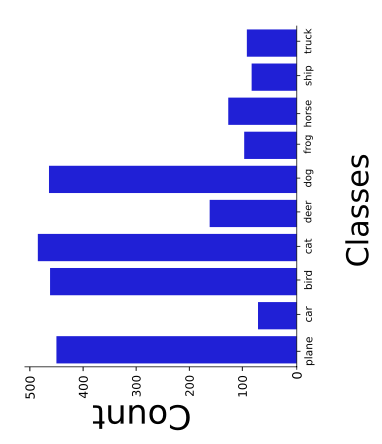

F is the failure set denoting the examples on which there is wrong prediction

In [7]:
F_mnist= create_failure_set(mnist_testloader, mnist_model)
print(np.array(F_mnist[0][0]).shape)

NameError: name 'mnist_testloader' is not defined

In [37]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

In [38]:
# torch.save(mnist_model.state_dict(), 'mnist_model.pth')
# torch.save(cifar_model.state_dict(), 'cifar_model.pth') was used to save model for easier use. 

## Identifying failure causes: 
1) Annotation noise<br>
2) Random Input noise <br>
3) Adversarial poisoning<br>

1) Adding label noise to the dataset: first defining the confusion matrices as defined in the paper for both mnist and cifar10.

In [39]:
# Assuming you have the confusion matrix defined as confusion_matrix
# MNIST confusion matrix
# Initialize a 10x10 confusion matrix with ones on the diagonal
mnist_cm = np.eye(10)
# Set misclassification probabilities
mnist_cm[1, 1] = 0.6 
mnist_cm[7, 7] = 0.6  
mnist_cm[1, 7] = 0.4  # Probability of misclassifying label 1 as label 7
mnist_cm[7, 1] = 0.4  # Probability of misclassifying label 7 as label 1
mnist_cm[6, 6] = 0.7  
mnist_cm[9, 9] = 0.7  
mnist_cm[6, 9] = 0.3  # Probability of misclassifying label 6 as label 9
mnist_cm[9, 6] = 0.3  # Probability of misclassifying label 9 as label 6
print(mnist_cm)

[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.  0.  0.  0.  0.4 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.3]
 [0.  0.4 0.  0.  0.  0.  0.  0.6 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.  0.  0.7]]


In [37]:
# List of label names
label_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Create a dictionary mapping label names to numerical labels starting from 0
label_map = {label_names[i]: i for i in range(len(label_names))}
# Assuming you have the confusion matrix defined as confusion_matrix
# CIFAR-10 confusion matrix
# Initialize a 10x10 confusion matrix with ones on the diagonal
cifar_cm = np.eye(10)
# Set misclassification probabilities
cifar_cm[label_map['plane'], label_map['plane']] = 0.6
cifar_cm[label_map['bird'], label_map['bird']] = 0.6 
cifar_cm[label_map['plane'], label_map['bird']] = 0.4 # Probability of misclassifying airplane as bird
cifar_cm[label_map['bird'], label_map['plane']] = 0.4 # Probability of misclassifying bird as airplane 
cifar_cm[label_map['cat'], label_map['cat']] = 0.7
cifar_cm[label_map['dog'], label_map['dog']] = 0.7
cifar_cm[label_map['cat'], label_map['dog']] = 0.3
cifar_cm[label_map['dog'], label_map['cat']] = 0.3 # check these once, the paper gives a contradictory cm. 
# print(cifar_cm)
# Print label names along with the confusion matrix
print('\t' + '\t'.join(label_names))
for i in range(len(label_names)):
    print(label_names[i], '\t', end='')
    print('\t'.join(str(cifar_cm[i, j]) for j in range(len(label_names))))


	plane	car	bird	cat	deer	dog	frog	horse	ship	truck
plane 	0.6	0.0	0.4	0.0	0.0	0.0	0.0	0.0	0.0	0.0
car 	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
bird 	0.4	0.0	0.6	0.0	0.0	0.0	0.0	0.0	0.0	0.0
cat 	0.0	0.0	0.0	0.7	0.0	0.3	0.0	0.0	0.0	0.0
deer 	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0
dog 	0.0	0.0	0.0	0.3	0.0	0.7	0.0	0.0	0.0	0.0
frog 	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0
horse 	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0
ship 	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0
truck 	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0


In [11]:
def flip_labels(dataloader, cm):
    noisy_labels = []
    misclassifcn_dict= {i: 0 for i in range(10)}
    for _, labels in dataloader:
        for label in labels:
            # Randomly flip the label according to the confusion matrix
            noisy_label = np.random.choice(np.arange(len(cm)), p=cm[label])
            if(noisy_label!=label):
                # print(label.shape, label)
                misclassifcn_dict[int(label.numpy())]+=1 # label is a tensor so conversion is needed to access dict keys
            noisy_labels.append(noisy_label)
						
    return noisy_labels, misclassifcn_dict

# Apply noise to the training labels
noisy_mnist_labels, missclassfcn_dict = flip_labels(mnist_testloader, mnist_cm)
# using these noisy labels will be equivalent to adding annotation noise
# print(len(noisy_mnist_labels))
# print(missclassfcn_dict)

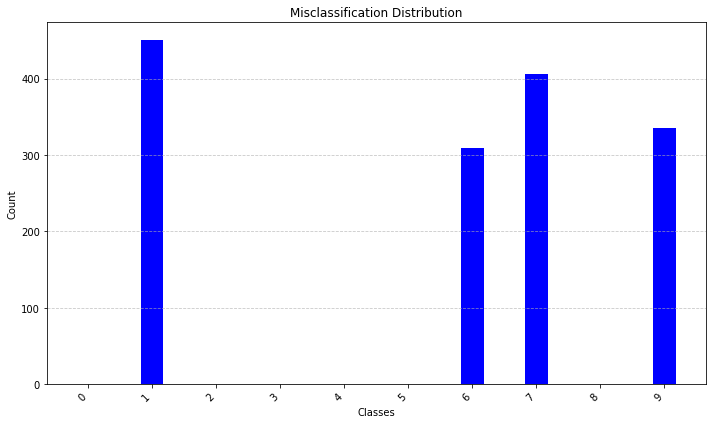

In [58]:
def plot_histogram(misclassfcn_dict, label_names=None):
    if label_names is None:
        label_names = [str(i) for i in range(10)]
    plt.figure(figsize=(10, 6))
    bins = np.arange(len(label_names) + 1)  # Define bin edges
    width = 0.35  # Width of each bar
    for idx, (label, freq) in enumerate(misclassfcn_dict.items()):
        plt.bar(idx, freq, width, label=label_names[label], color='blue')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Misclassification Distribution')
    plt.xticks(np.arange(len(label_names)), label_names, rotation=45, ha='right')
    # plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot histogram
plot_histogram(misclassfcn_dict=missclassfcn_dict)


This corresponds with the MNIST one given. But why is the count for 1 so low in the paper? Also, why are the other numbers non zero in the paper? Do we have to introduce a non zero noise for all the classes? 

In [33]:
print(len(mnist_trainloader)*64, len(mnist_testloader)*64, len(mnist_valloader)*64)
# 10% of training set(6000) is used for validation, leaving 54k in the training set of mnist. 

54016 10048 6016


In [73]:
# Define the root directory for data
data_root = './data'
# Define preprocessing transformations
transform1 = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

mnist_trainset1 = torchvision.datasets.MNIST(root=data_root, train=True, download=False, transform=transform1)
mnist_testset1 = torchvision.datasets.MNIST(root=data_root, train=False, download=False, transform=transform1)

cifar_trainset1 = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=transform1)
cifar_testset1 = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=transform1)

2) Random input noise

Original (Label: 1) | Noisy (Label: 1)


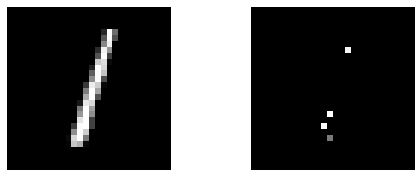

Original (Label: 7) | Noisy (Label: 7)


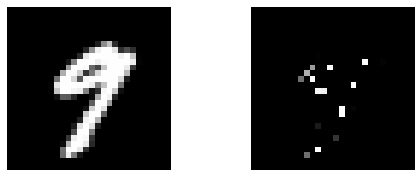

Original (Label: 1) | Noisy (Label: 1)


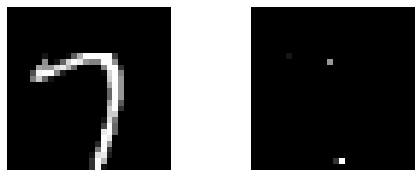

In [86]:
# inages of both the datasets are constrained between 0 and 1, with 0 meaning black. 
def input_noise(dataset, classes, gamma=0.3, mode="Gaussian", num_examples=2):
    assert mode in ["Salt and Pepper", "Gaussian"], "Mode must be either 'Salt and Pepper' or 'Gaussian'"
    assert 0 <= gamma <= 1, "Gamma must be in the range [0, 1]"
    
    noisy_images = []
    bar = 0
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        if label in classes:
                temp = image.clone()  # Create a copy of the image tensor
                noisy_image = None
                if np.random.rand() < gamma:  # Apply noise with probability gamma
                    if mode == "Salt and Pepper":
                        noisy_image = add_salt_and_pepper_noise(temp)
                    elif mode == "Gaussian":
                        noisy_image = add_gaussian_noise(temp)
                    if bar < num_examples:
                        # Print the original and noisy images for a few examples
                        print("Original (Label: {}) | Noisy (Label: {})".format(label, label))
                        show_images_in_one_row(temp, noisy_image)
                        bar += 1
                else:
                    noisy_image = temp
        else:
                temp = image
                noisy_image = temp
                
        noisy_images.append(noisy_image)
    return noisy_images

def add_salt_and_pepper_noise(image):
    # print(image)
    noisy_image = image.clone()
    mask = torch.rand_like(image) < 0.9 # Salt and pepper noise with equal probability
    # mask1 = !mask  # Salt and pepper noise with equal probability
    noisy_image[mask] = 0
    # noisy_image[~mask]+= 
    # mask = torch.rand_like(image) < 0.5
    # noisy_image[mask] = 255
    return noisy_image

def add_gaussian_noise(image):
    noisy_image = image.clone()
    noise = torch.randn_like(image) # Standard deviation of 25 for Gaussian noise
    noisy_image += noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

def show_images_in_one_row(image1, image2):
    plt.figure(figsize=(8, 3))
    if image1.shape[0] == 3:  # RGB image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.permute(1, 2, 0))  # Permute to move channel dimension to the last
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.permute(1, 2, 0))
        plt.axis('off')
    else:  # Grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

noisy_images = input_noise(mnist_testset1, [1, 7, 6, 9], gamma=0.3, mode="Salt and Pepper", num_examples=3)



Original (Label: 4) | Noisy (Label: 4)


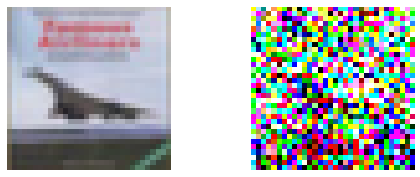

Original (Label: 5) | Noisy (Label: 5)


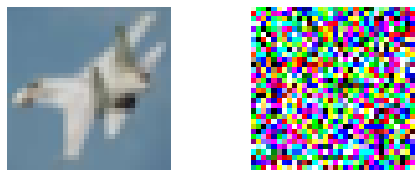

Original (Label: 5) | Noisy (Label: 5)


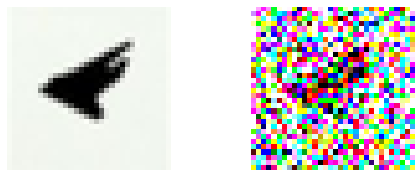

In [88]:
noisy_images = input_noise(cifar_testset1, [0, 2, 3, 5], gamma=0.3, mode="Gaussian", num_examples=3)

3) Adversarial attack using FGSM

FGSM: fast gradient sign method attack, which is a white box attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. Gradients are taken with respect to the input image. https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
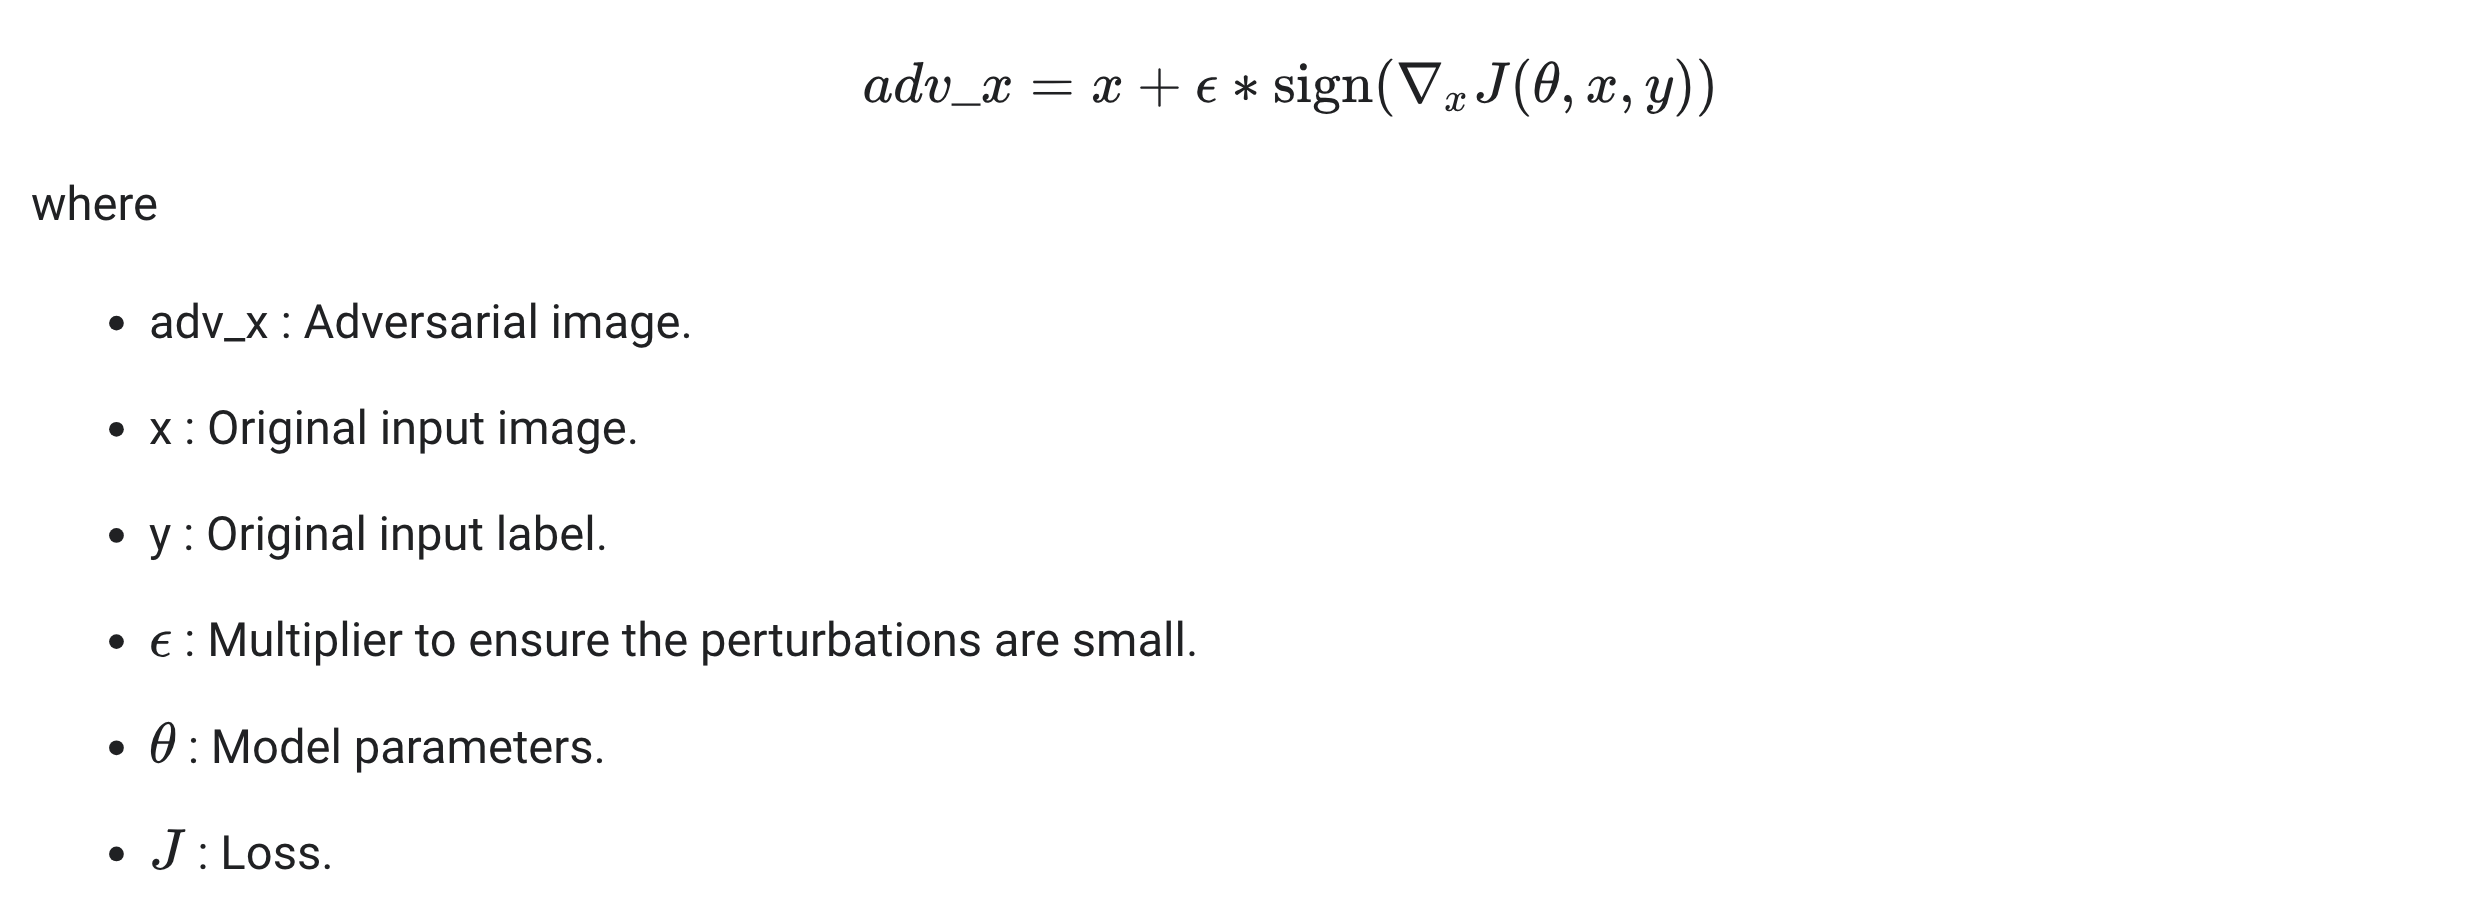

Original (Label: 9) | Noisy (Label: 8)


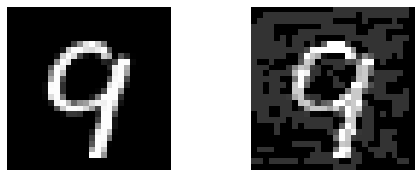

Original (Label: 7) | Noisy (Label: 8)


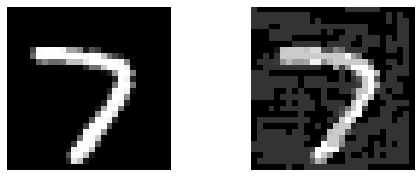

Original (Label: 6) | Noisy (Label: 8)


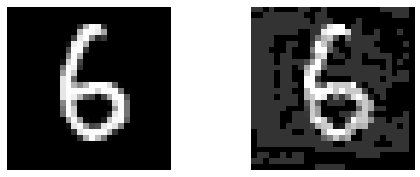

In [114]:
# Function to craft adversarial examples using FGSM
def fgsm_attack(model, image, label, epsilon=0.1):
    image.requires_grad = True # need to store gradients of images 
    # print(image.shape) (1, 28, 28)
    image1= image.unsqueeze(0)
    # print(image1.shape) (1, 1, 28, 28)
    label1= torch.tensor(label).unsqueeze(0) # label is initially an integer, need to convert to tensor before passing to loss. 
    # print(label1.shape)
    outputs = model(image1) # This is a probability distribution over the ten classes, needed for loss
    loss = criterion(outputs, label1)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    noise=  epsilon * torch.sign(data_grad)
    perturbed_image = image + noise
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Clip perturbed data to [0, 1] range
    perturbed_label= int(model(perturbed_image.unsqueeze(0)).argmax(1)) # find the label predicted for the adversarial image. 
    image.requires_grad = False # detaching from gradient calculation
    # perturbed_image.requires_grad = False : cannot be done, only leaf nodes can be attached/detached
    return image, noise, perturbed_image, perturbed_label


# Function to apply adversarial perturbations to create new poisoned data
def adversarial_poisoning(dataset, classes, victim_model, epsilon=0.2, contamination_rate=0.3, num_examples= 3):
    poisoned_data = []
    bar= 0
    dataset_new= copy.deepcopy(dataset) # operate on a clone of the images. 
    for idx in range(len(dataset_new)): #batchwise loop
        image, label= dataset_new[idx]
        if label in classes and np.random.rand()<contamination_rate:	#contaminate from the given classes with a probability 0.3
            image, noise, perturbed_image, perturbed_label = fgsm_attack(victim_model, image, label, epsilon)  # images are cloned. 
            if bar < num_examples:
                        # Print the original and noisy images for a few examples
                        print("Original (Label: {}) | Noisy (Label: {})".format(label, perturbed_label))
                        show_images_in_one_row(image, perturbed_image)
                        bar += 1
            poisoned_data.append((perturbed_image, label))
    return poisoned_data


def show_images_in_one_row(image1, image2):
    # print(image1.shape, image2.shape)
    plt.figure(figsize=(8, 3))
    if image1.shape[0] == 3:  # RGB image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.permute(1, 2, 0))  # Permute to move channel dimension to the last
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.permute(1, 2, 0))
        plt.axis('off')
    else:  # Grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(image1.detach().squeeze(), cmap='gray') # detach used because error in squeezing when we're still calculatiing grads? 
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(image2.detach().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

poisoned_data = adversarial_poisoning(mnist_testset1, [1, 7, 6, 9], mnist_model)
# poisoned_data = adversarial_poisoning(cifar_testset1, [1, 7, 6, 9], cifar_model) # cifar model is not good enough rn. 

As we can see, adding even a small amount of noise to the target classes has made the predicted output by the models wrong (0 predicted as 7, 6 predicted as 8 etc. )

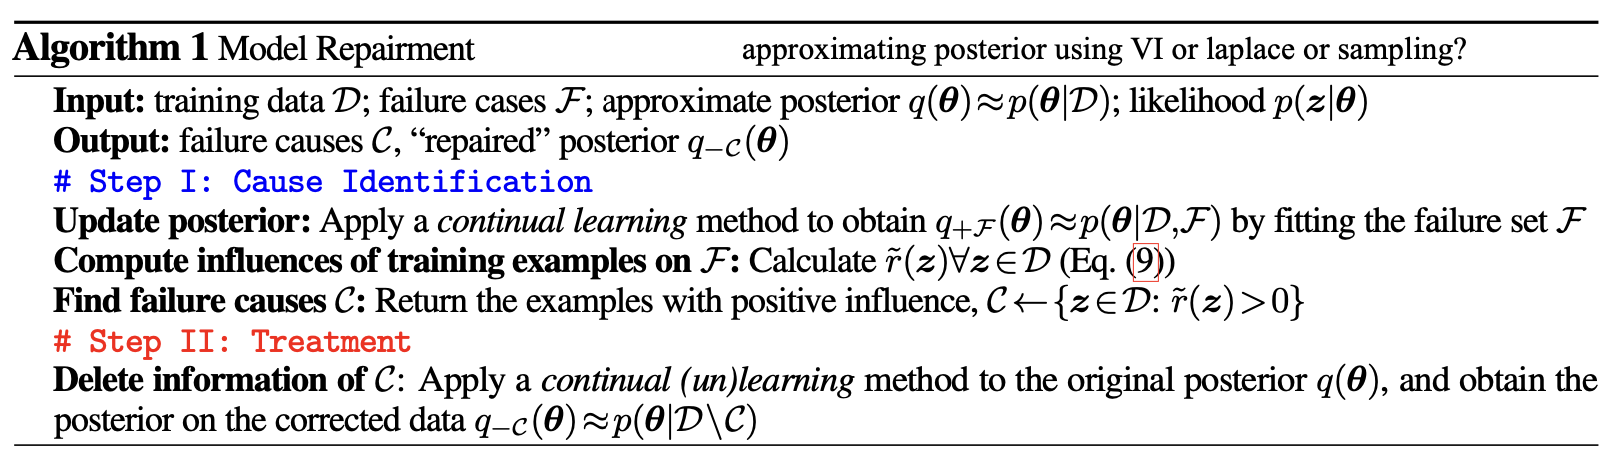

We have right now learnt a point estimate rather than a posterior on theta, and have written code for identifyinhg failure set F. The next step is first to find the approximate posterior q(θ) ~ p(θ|D). Then we will appply a continual learning method to obtain the modified posterior q+F(θ) ~ p(θ|D, F) after fitting failure set F. In order to find a subset C of cardinality K that leads to the maximal ˆr(C), it suffices to compute ˆr(z) for every training example z ∈ D and find the top K examples with largest ˆr(z) values. We show two methods of approximating ˆr(z): Linear influence functions and EWC.

The fisher matrix is used extensively in the upcoming methods. Fisher Information Matrix (FIM) is covariance matrix of score function <br>For a single data point, $F(x) = \mathbb{E}_{p_{\theta}(y|x)}[\nabla_{\theta} \log p_{\theta}(y|x) (\nabla_{\theta} \log p_{\theta}(y|x))^{\top}]$. For an entire dataset, we have $F = \sum_{n} F_{x_n} = \sum_{n} \mathbb{E}_{p_{\theta}(y|x_n)}[\nabla_{\theta} \log p_{\theta}(y|x_n) (\nabla_{\theta} \log p_{\theta}(y|x_n))^{\top}]
$ Each entry 𝐹 tells us how “sensitive” the model is w.r.t. the pair $(\theta_i , \theta_j )$. <br> In practise, we use the emperical fisher matrix $\tilde{F} = \sum_{n} [\nabla_{\theta} \log p_{\theta}(y_n|x_n) (\nabla_{\theta} \log p_{\theta}(y_n|x_n))^{\top}]$. The difference, of course, is that rather than sampling y
 from the model itself, here, we use the observed labels $y_n$
 from the dataset



## Influence functions :
They are used to answer the question: why did the model make a prediction? Which training points were most responsible for this prediction? Upweight and downwight contribution of each image by changing loss function. Upwieghting a training image means that the model will try a little harder to fit that particular image. 
https://www.youtube.com/watch?v=0w9fLX_T6tY&t=75s<br>
code: https://github.com/kohpangwei/influence-release

After observing the set of failures $ F $, a point estimate of $ p(\theta|D,F) $ is obtained by performing a single update of natural gradient ascent on the log likelihood of $ F $ with step size $ \gamma > 0 $: $ q^+(θ)=δ(θ−θ_{+F}) \approx p(θ|D,F)$

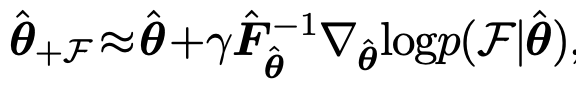  where Fˆθˆ is the empirical Fisher information matrix, which is different from the Fisher matrix explained [here](https://www.inference.vc/on-empirical-fisher-information/#:~:text=The%20Fisher%20and%20the%20empirical,changes%20in%20the%20parameters%20%CE%B8.)

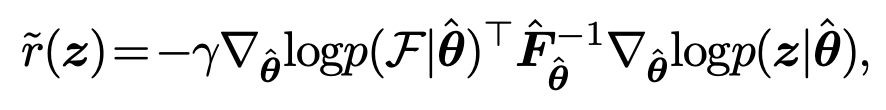, z = (x,y)

The per-instance formulation Eq. (8) has similar interpretation as the “predictive” formula Eq. (5), in that ˆr(z) measures how much the predictive moments of z changes when the model is further trained on F, i.e., computation of p(θ|D,F). If the difference is positive, i.e., ˆr(z) > 0, it means the example z ∈ D is a conflicting evidence against the test examples in F; conversely, if ˆr(z)<0, then z and F are aligned. In practice, the failure causes correspond to examples z with ˆr(z)>0. We are using the log likelihood of $\mathcal{F}$ given $\hat{\theta}$. 

The expression $ \tilde{r}(z) := \mathbb{E}_{q{(\theta)}}[\log p(z|\theta)] - \mathbb{E}_{q_{+\mathcal{F}}}[\log p(z|\theta)] $ comes out as $ r(z) = -\gamma \nabla_{\hat{\theta}} \log p(\mathcal{F}|\hat{\theta})^{\top} \hat{F}^{-1}_{\hat{\theta}} \nabla_{\hat{\theta}} \log p(z|\hat{\theta}) $ in linear influence when we use a point estimate of $p(\theta|D,F)$ by performing a single update of natural gradient ascent [16] on the log likelihood of $\mathcal{F}$ with step size $\gamma > 0$

In [19]:
# print(np.array(failure_set).shape)

(104, 1, 28, 28)


In [40]:
mnist_model.load_state_dict(torch.load('mnist_model.pth'))

<All keys matched successfully>

### Computing FIM
An outer product is the tensor product of two vectors $ \mathbf{u} = [u_1, u_2, \ldots, u_m] $ and $ \mathbf{v} = [v_1, v_2, \ldots, v_n] $, denoted by $ \mathbf{u} \otimes \mathbf{v} $, is an $ m \times n $ matrix $ \mathbf{W} $ such that its coordinates satisfy $ w_{i,j} = u_i v_j^* $. The outer product $ \mathbf{u} \otimes \mathbf{v} $ is equivalent to a matrix multiplication $ \mathbf{u} \mathbf{v}^* $ (or $ \mathbf{u} \mathbf{v}^T $ if vectors are real) provided that $ \mathbf{u} $ is represented as a column $ m \times 1 $ vector, and $ \mathbf{v} $ as a column $ n \times 1 $ vector. Here $ v^* = \overline{v^T} $. So when we are calculating the emperical FIM, if we calculate the vector $ \mathbf{u}$ of gradients $\nabla_{\theta} \log p_{\theta}(y_n|x_n)$ and do the outer product with itself, we will get back $\tilde{F} = \sum_{n} [\nabla_{\theta} \log p_{\theta}(y_n|x_n) (\nabla_{\theta} \log p_{\theta}(y_n|x_n))^{\top}]$ of size n*n. The empirical Fisher Information Matrix (FIM) is an approximation of the true FIM, which is defined as the expected value of the outer product of the gradients of the log-likelihood function with respect to the parameters. The empirical FIM is computed by taking the sum of the Hessians of the negative log-likelihood function with respect to the parameters, evaluated at the data points.

In [22]:
def compute_fisher_information(model, dataset):
    fisher_information = 0
    for x, y in tqdm(dataset, desc="Computing Fisher Information"):
        model.zero_grad()
        logits = model(x.unsqueeze(0))  # Forward pass
        log_probs = F.log_softmax(logits, dim=1)  # Compute log probabilities
        log_likelihood = log_probs[0, y]  # Log likelihood of true label
        log_likelihood.backward()  # Backpropagate to compute gradients
        grad_params = [param.grad.clone().detach() for param in model.parameters()]  # Clone gradients
        grad_params = torch.cat([grad.view(-1) for grad in grad_params])  # Flatten gradients
        fisher_information += torch.outer(grad_params, grad_params)
    return fisher_information / len(dataset)

This method(basic) for calculating FIM failed because it is very computationally heavy since there are a large number of parameters even for MNIST ~65k. The kernel will crash in the outer product when we have less compute(this is even before the inversion step of such a large matrix). We require forming and inverting $\hat{F}(\hat{\theta}) = \dfrac{\sum_{i=1}^n \nabla_\theta^2 L(z_i,\hat{\theta})}{n} $,
the Hessian of the empirical risk. With n training points and $\theta \in R^p$, this requires $O(np^2 + p^3)$ operations. As stated in the paper,to avoid the expensive computation of $ \hat{F}^{-1} $, Koh & Liang [[8]](https://github.com/kohpangwei/influence-release/tree/master) introduced two efficient approximations to the Hessian-vector product $ \hat{F}^{-1} \nabla_{\theta} \log p(\mathcal{F}|\theta) $: the first method finds $ v $ that minimizes $ v^T \hat{F}^{-1} \nabla_{\theta} v - \log p(\mathcal{F}|\theta)^T v $ using gradient descent (GD), while the second method uses an iterative algorithm for stochastic approximation (SA) from [[45]](https://github.com/sato9hara/sgd-influence). We implement these two variants (GD & SA) of linear influence in PyTorch and utilize the original implementation for SGD-influence.
So we look at 4 algos for cause identification: <br>
1) SGD influence(used from [here](https://github.com/sato9hara/sgd-influence)), to run go to Sec72 folder in sgd-influence/experiments<br>
2) Linear influence- GD<br>
3) Linear influence- SA<br>
4) EWC influence <br>

## Linear influence gd: 
$\arg \min_v{v^T F_\theta \nabla_\theta v - \log p(\mathcal{F})^T v}$

In [53]:
def hessian_vector_product(y, xs, v):
    """
    Multiply the Hessian of `y` wrt `xs` by `v`.
    """
    grads = torch.autograd.grad(y, xs, create_graph=True)
    grad_v = [grad.contiguous().view(-1) @ v_elem.contiguous().view(-1) for grad, v_elem in zip(grads, v)]
    hessian_v = torch.cat([torch.autograd.grad(elem, xs, retain_graph=True)[0].contiguous().view(-1) for elem in grad_v])
    return hessian_v

def empirical_fisher(model, data_loader, target_class=None):
    """
    Compute the empirical Fisher Information Matrix (FIM) for the given model and data loader.
    """
    num_params = sum(p.numel() for p in model.parameters())
    empirical_fim = torch.zeros(num_params)

    for inputs, labels in data_loader:
        log_probs = model.log_prob(inputs)
        
        if target_class is not None:
            log_probs = log_probs[:, target_class]
        
        neg_log_likelihood = -torch.sum(log_probs)
        
        params = list(model.parameters())
        hessian_vec_prods = hessian_vector_product(neg_log_likelihood, params, [torch.randn_like(p) for p in params])
        
        empirical_fim += hessian_vec_prods
    
    return empirical_fim

# Example usage
model = MNIST_CNN()
failure_loader = create_failure_set(mnist_testloader, mnist_model)
empirical_FIM = empirical_fisher(mnist_model, failure_loader)
print(empirical_FIM.shape)

# Example usage
model = MNIST_CNN()
failure_loader = create_failure_set(mnist_testloader, mnist_model)
empirical_FIM = empirical_fisher(mnist_model, failure_loader)
print(empirical_FIM.shape)

The size of the failure set is  104


RuntimeError: The size of tensor a (65642) must match the size of tensor b (2880) at non-singleton dimension 0

In [51]:
print(type(empirical_FIM), empirical_FIM)

<class 'torch.Tensor'> tensor(-72273.8203)


In [ ]:
def linear_influence_gd(model, theta_hat, failure_loader, lr, num_steps):
    # Check if theta_hat is empty
    if not theta_hat:
        raise ValueError("theta_hat is empty. Please provide non-empty parameters.")

    # Concatenate all parameters in theta_hat into a single vector
    theta_hat_flat = torch.cat([p.view(-1) for p in theta_hat])

    # Initialize v with random values, with the same shape as theta_hat_flat
    v = torch.randn_like(theta_hat_flat, requires_grad=True)
    optimizer = torch.optim.SGD([v], lr=lr)  # Initialize optimizer for v

    # Perform optimization steps
    for _ in tqdm(range(num_steps)):
        optimizer.zero_grad()  # Zero the gradients
        log_likelihood = 0  # Initialize log likelihood

        # Compute the log likelihood for each batch in the failure loader
        for x, _ in failure_loader:
            log_probs = model.log_prob(x)
            log_likelihood += torch.sum(log_probs)

        log_likelihood.backward(retain_graph=True)  # Backpropagate through log likelihood
        grad_log_likelihood = torch.cat([p.grad.clone().detach().view(-1) for p in model.parameters()])  # Extract gradients of log likelihood
        
        v_grad_product = torch.dot(v, grad_log_likelihood)

        loss = -v_grad_product - log_likelihood  # Define loss function
        loss.backward()  # Backpropagate through loss
        optimizer.step()  # Take a gradient descent step for v

    return -v  # Return the optimized v

In [44]:
def linear_influence_sa(model, theta_hat, failure_loader, lr, num_steps):
    v = torch.randn_like(next(iter(theta_hat)))  # Convert generator to tensor
    for _ in range(num_steps):
        log_likelihood = 0
        for x, _ in failure_loader:
            log_likelihood += torch.sum(model.log_prob(x))
        log_likelihood.backward()
        grad_log_likelihood = next(iter(theta_hat)).grad.clone().detach()  # Convert generator to tensor
        v_grad_product = torch.dot(v, grad_log_likelihood)
        v -= lr * (v_grad_product + log_likelihood) * grad_log_likelihood
    
    return -v

# Example usage



The size of the failure set is  104


  1%|          | 1/100 [00:00<00:39,  2.51it/s]

torch.Size([32])


  2%|▏         | 2/100 [00:00<00:38,  2.56it/s]

torch.Size([32, 32, 3, 3])


  3%|▎         | 3/100 [00:01<00:37,  2.57it/s]

torch.Size([32])


  4%|▍         | 4/100 [00:01<00:37,  2.58it/s]

torch.Size([64, 32, 3, 3])


  5%|▌         | 5/100 [00:01<00:36,  2.58it/s]

torch.Size([64])


  6%|▌         | 6/100 [00:02<00:36,  2.59it/s]

torch.Size([64, 64, 3, 3])


  7%|▋         | 7/100 [00:02<00:35,  2.59it/s]

torch.Size([64])


  7%|▋         | 7/100 [00:02<00:39,  2.38it/s]

torch.Size([10, 64])


RuntimeError: The size of tensor a (3) must match the size of tensor b (64) at non-singleton dimension 3

In [ ]:
theta_hat = mnist_model.parameters()  # Assuming theta_hat is the parameter vector of the mnist_model
failure_loader = create_failure_set(mnist_testloader, mnist_model)  # Failure set DataLoader
lr = 0.01  # Learning rate
num_steps = 100  # Number of optimization steps

linear_influence_gd_result = linear_influence_gd(mnist_model, theta_hat, failure_loader, lr, num_steps)


print("Linear Influence (GD):", linear_influence_gd_result)


In [ ]:
linear_influence_sa_result = linear_influence_sa(mnist_model, theta_hat, failure_loader, lr, num_steps)
print("Linear Influence (SA):", linear_influence_sa_result)

In [ ]:
# Function to compute the linear influence function
def linear_influence_function(model, theta_hat, failure_set, gamma):
    # Compute the gradient of the log likelihood of the failure set
    model.zero_grad()
    log_likelihood = torch.zeros(1)  # Initialize log likelihood
    print("Hello")
    for x, y in failure_set:
        logits = model.forward(x.unsqueeze(0))  # Forward pass
        log_probs = F.log_softmax(logits, dim=1)  # Compute log probabilities
        log_likelihood += log_probs[0, y]  # Add log probability of true label
    log_likelihood.backward()  # Backpropagate to compute gradients
    print("yo")
    grad_log_likelihood = [param.grad.clone() for param in model.parameters()]  # Clone gradients
    # for grad in grad_log_likelihood:
    #     print(grad.shape)
    # torch.Size([32, 1, 3, 3])
	# torch.Size([32])
	# torch.Size([32, 32, 3, 3])
	# torch.Size([32])
	# torch.Size([64, 32, 3, 3])
	# torch.Size([64])
	# torch.Size([64, 64, 3, 3])
	# torch.Size([64])
	# torch.Size([10, 64])
	# torch.Size([10])
    # print(grad_log_likelihood[0].shape) : [32, 1, 3, 3]
    # print(len(grad_log_likelihood)) : 10
    # Compute the empirical Fisher information matrix
    print("yo1")
    fisher_information = compute_fisher_information(model, failure_set)
    print(fisher_information.shape) #:torch.Size([65642])
    inv_FIM= torch.inverse(fisher_information) 
    print(inv_FIM.shape)
    # Compute the linear influence function
    print(np.array(grad_log_likelihood).shape,torch.inverse(fisher_information).shape )
    linear_influence = -gamma * torch.matmul(grad_log_likelihood, torch.matmul(torch.inverse(fisher_information), grad_log_likelihood))
    return linear_influence


# Example usage
theta_hat = mnist_model.parameters()  # Assuming theta_hat is the parameter vector of the mnist_model
failure_set = create_failure_set(mnist_testloader, mnist_model)  # Failure set of (x, y) tuples
gamma = 1  # Step size for natural gradient ascent
fisher_information = compute_fisher_information(mnist_model, failure_set)
# linear_influence = linear_influence_function(mnist_model, theta_hat, failure_set, gamma)
# print(linear_influence)
# 

NameError: name 'mnist_testloader' is not defined

## Elastic weight consolidation:

The EWC (Elastic Weight Consolidation) method approximates the posterior $ p(\theta | D, F) $ by first performing a Laplace approximation of the original posterior $ p(\theta | D) $ around the point estimate $ \hat{\theta} $, and subsequently finding the MAP (Maximum A Posteriori) solution of $ \theta $. Formally, $ \hat{\theta}_{+F} $ is obtained by maximizing the objective below with respect to $ \theta $ via SGD (Stochastic Gradient Descent):
$ \log p(\mathcal{F} | \theta) - \frac{N}{2} (\theta - \hat{\theta})^T F(\hat{\theta}) (\theta - \hat{\theta}) - \frac{\lambda}{2} ||\theta - \hat{\theta}||^2 $
where the off-diagonal elements of $ F(\hat{\theta}) $ are dropped for memory reasons in practice. Intuitively, the first term encourages high accuracy on the failure set $ \mathcal{F}$, while the second/third terms ensure the model parameters do not deviate too much in distribution. Defining $ q(\theta) = \delta(\theta - \hat{\theta}) $ and $ q_{+F}(\theta) = \delta(\theta - \hat{\theta}_{+F}) $, we have that
$ \tilde{r}(z) = \log p(z | \hat{\theta}) - \log p(z | \hat{\theta}_{+F}) $
To compute the above for each datapoint $ z \in D $, we only need to solve the optimization problem of Eq. (12) by SGD once. We refer to this version of $ \tilde{r}(z) $ as the EWC-influence function.

1. **Initialization**: Start with the estimate of the model parameters, denoted as $ \hat{\theta} $, which is obtained from `model.parameters()`.

2. **Objective Function**: Define the objective function to maximize via SGD:
   $$ \log p(\mathcal{F} | \theta) - \frac{N}{2} (\theta - \hat{\theta})^T F(\hat{\theta}) (\theta - \hat{\theta}) - \frac{\lambda}{2} ||\theta - \hat{\theta}||^2 $$
   - $ \mathcal{F} $ represents the failure loader.
   - $ F(\hat{\theta}) $ represents a diagonal representation of the empirical Fisher matrix.
   - $ N $ is the size of the training dataset, which can be obtained from `train_loader`.
   - $ \lambda $ is a regularization parameter to keep the updated $ \theta_{+F} $ close to the original $ \hat{\theta} $.

3. **SGD Optimization**: Perform Stochastic Gradient Descent (SGD) to find $ \theta_{+F} $. This is the MAP solution.

4. **EWC-influence Computation**: For every training point $ z $:
   $$ \tilde{r}(z) = \log p(z | \hat{\theta}) - \log p(z | \hat{\theta} + F) $$
   Compute the difference between the log likelihood of $ z $ under $ \hat{\theta} $ and $ \hat{\theta}_{+F} $.

This process ensures that $ \theta_{+F} $ is obtained by maximizing the likelihood of the failure set while keeping the updated parameters close to the original ones. Then, the EWC-influence for each training point is computed based on the difference in log likelihoods between the original and updated parameters.

In [77]:
import torch.nn.functional as F
def get_fisher_diag(model, dataset, params, empirical=True):
    fisher = {}
    for n, p in copy.deepcopy(params).items():
        p.data.zero_()
        fisher[n] = (p.data)

    model.eval()
    for input, gt_label in tqdm(dataset, desc="Computing Fisher Diag", leave=False):
        model.zero_grad()
        output = model(input)
        if empirical:
            label = gt_label
        else:
            label = output.max(1)[1].view(-1)
        log_probs = F.log_softmax(output, dim= 1)  # Compute log probabilities
        # print(log_probs.shape, label.shape)
        negloglikelihood = F.nll_loss(log_probs, label)  # Calculate negative log likelihood loss
        # negloglikelihood = F.nll_loss(F.log_softmax(output, dim=1), label)
        negloglikelihood.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher


In [14]:
params = {n: p for n, p in mnist_model.named_parameters() if p.requires_grad}
# Mnist model has only ten named parameters, using torch.cat with .view(-1) on the params will give ~65k params. 
print(len(params))
fisher= get_fisher_diag(mnist_model, mnist_trainloader, params)
# print(fisher.keys())
# for k in fisher:
#     print(fisher[k].shape)
#ict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'fc.weight', 'fc.bias'])
# torch.Size([32, 1, 3, 3])
# torch.Size([32])
# torch.Size([32, 32, 3, 3])
# torch.Size([32])
# torch.Size([64, 32, 3, 3])
# torch.Size([64])
# torch.Size([64, 64, 3, 3])
# torch.Size([64])
# torch.Size([10, 64])
# torch.Size([10])

10


In [16]:
# Save dictionary to .pkl
with open('fisher.pkl', 'wb') as f:
    pickle.dump(fisher, f)

In [41]:
with open('fisher.pkl', 'rb') as f:
    fisher = pickle.load(f)

In [16]:
print(len(mnist_trainloader.sampler))

54000


In [98]:
def find_theta_F(theta_hat, fisher, failure_loader, model, lr, lambda_val, num_epochs, N):
    """
    Update theta to obtain theta_F using SGD.

    Args:
        theta_hat: Torch tensor representing the MAP point estimate of the model parameters.
        F_hat_theta_hat: Torch tensor representing the diagonal entries of the empirical Fisher information matrix.
        lambda_val: Regularization parameter.
        num_epochs: Number of epochs for SGD.
        data_loader: DataLoader for the training dataset.
        model: Trained neural network model.

    Returns:
        theta_F: Updated model parameters after adaptation using SGD.
    """

    theta_F = theta_hat.clone().detach().requires_grad_(True)
    optimizer = torch.optim.SGD([theta_F], lr=lr)
    FIM= torch.cat([fisher[param].view(-1) for param in fisher.keys()]).diag()
    print(FIM.shape)
    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in tqdm(failure_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            log_probs = F.log_softmax(outputs, dim=1)
            # print(log_probs.shape, labels.shape)
            # Compute negative log likelihood loss
            negloglikelihood = F.nll_loss(log_probs, labels)

            # Regularization term
            reg_term = 0.5 * lambda_val * torch.sum((theta_F - theta_hat) ** 2)
            fisher_term= N/2 * torch.sum(((theta_F - theta_hat).T@FIM@(theta_F - theta_hat)))
            loss = negloglikelihood - reg_term -fisher_term
            loss.backward()
            optimizer.step()

    return theta_F

In [18]:
print(type(theta_hat), len(theta_hat))


NameError: name 'theta_hat' is not defined

In [25]:
lr = 0.01
lambda_val = 0.1
num_epochs = 10
N= len(mnist_trainloader.sampler)
failure_loader = create_failure_set(mnist_testloader, mnist_model)
theta_hat= torch.cat([param.view(-1) for param in mnist_model.parameters()])
theta_F = find_theta_F(theta_hat, fisher, failure_loader, mnist_model, lr, lambda_val, num_epochs, N)

The size of the failure set is  104
torch.Size([65642, 65642])


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([64, 10]) torch.Size([64])


  0%|          | 0/10 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [79]:
def create_model_with_theta(theta):
    """
    Create a new model with parameters theta_F.

    Args:
        old_model: Trained neural network model.
        theta_F: Updated model parameters after adaptation using SGD.

    Returns:
        new_model: New neural network model with parameters theta_F.
    """
    new_model = MNIST_CNN()
    with torch.no_grad():
        for new_param, param_F in zip(new_model.parameters(), theta):
            new_param.copy_(param_F)
    return new_model

In [22]:
mnist_laplace_approx= create_model_with_theta(theta_F)
save_model(mnist_laplace_approx, 'mnist_laplace_approx.pth')
# print(mnist_newmodel.parameters())

In [43]:
mnist_laplace_approx= MNIST_CNN()
load_model(mnist_laplace_approx, 'mnist_laplace_approx.pth')

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [81]:
def compute_ewc_influences(data_loader, model, model_new):
    """
    Computes the EWC-influence for each training point.

    Args:
        data_loader: DataLoader for the training dataset.
        model: Trained neural network model.
        model_new: Updated neural network model after adaptation using EWC.

    Returns:
        influences: Tensor of EWC-influences for each training point.
    """

    influences = []

    model.eval()
    for inputs, labels in tqdm(data_loader, desc="Finding EWC influence"):
        # Compute log likelihood under original and adapted models
        log_probs_hat = F.log_softmax(model(inputs), dim=1)
        log_probs_hat_F = F.log_softmax(model_new(inputs), dim=1)

        # Compute EWC-influence for each data point in the batch
        ewc_influence = []
        for i in range(inputs.size(0)):
            label = labels[i].item()
            negloglikelihood_old = -log_probs_hat[i, label]
            negloglikelihood_new = -log_probs_hat_F[i, label]
            ewc_influence.append(negloglikelihood_old - negloglikelihood_new)
        
        influences.append(torch.tensor(ewc_influence))

    influences = torch.cat(influences)  # Concatenate the list of tensors
    return influences

# Compute EWC-influences for each training point


# Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute EWC-influences for each training point
# ewc_influences = compute_ewc_influences( mnist_trainloader, mnist_model, mnist_newmodel)

In [ ]:
ewc_influences = compute_ewc_influences(mnist_trainloader, mnist_model, mnist_laplace_approx)

In [14]:
# print((ewc_influences))
# blah= ewc_influences.sort(descending= True)
# print(blah[0])
# print(ewc_influences[0].shape)


In [45]:
def find_failure_causes(data_loader, influences, top_k=None):
    """
    Find failure causes C: Return the examples with positive influence.

    Args:
        data_loader: DataLoader for the training dataset.
        influences: List of EWC-influences for each training point.
        top_k: Number of top points to select based on influence. If None, return all points with positive influence.

    Returns:
        failure_causes: List of examples with positive influence (C).
    """
    failure_causes = []

    # Sort influences and get indices of points with positive influence
    sorted_indices = sorted(range(len(influences)), key=lambda i: influences[i], reverse=True)
    # This sorts indices, not the list of influences. 
    positive_indices = [i for i in sorted_indices if influences[i] > 0]

    if top_k is not None:
        # Select top k points with positive influence
        selected_indices = positive_indices[:top_k]
    else:
        # Select all points with positive influence
        selected_indices = positive_indices
    print(selected_indices)
    # Extract examples with positive influence
    for idx in selected_indices:
        example = data_loader.dataset[idx]  # Assuming data_loader.dataset provides access to individual examples
        failure_causes.append(example)

    return failure_causes, selected_indices


In [46]:
# Find failure causes C
top_k = None  # Change to desired value if you want to select top k points
failure_causes, failure_indices = find_failure_causes(mnist_trainloader, ewc_influences, top_k)
print(len(failure_causes))

[18822, 38733, 7396, 12717, 44424, 35465, 18527, 8362, 19826, 35366, 26069, 39963, 53813, 42454, 47137, 7072, 27246, 11112, 9014, 36725, 8943, 35658, 38207, 14395, 32118, 5078, 34472, 41409, 45558, 10054, 39290, 6186, 2560, 9367, 4691, 37266, 40226, 8157, 26857, 34604, 51134, 53063, 25827, 17923, 28228, 50058, 14949, 34826, 16201, 9303, 34206, 47361, 20486, 42677, 24417, 38029, 339, 24597, 14200, 21109, 19573, 53312, 37205, 2523, 29860, 14146, 13507, 5743, 17682, 50628, 9077, 15762, 30270, 11957, 13398, 41002, 44698, 27233, 2413, 3247, 51478, 45938]
82


## Model treatment

Once the causes C of the failures F are identified among the training data D, we seek to repair the model q(θ) by erasing the memories of C. We formalise this problem as the computation of the posterior p(θ|D\C), i.e., C is absent from the training data D. A naive approach would re-run approximate inference on the whole “corrected” dataset D\C to obtain an approximate posterior $q_{−C}$(θ)$≈p(θ|D\C) which can be time consuming. But more fundamentally, by doing so, the obtained $q_{−C}$(θ) may be unrelated to the original q(θ) based on which C were identified, due to, e.g. non-convex SGD optimisation issues. Moreover, this “model replacement” approach may not maintain other good properties of the original model q(θ).<br>
In other words, we can treat the approximation of p(θ|D\C) as a continual learning task, where the task is to “unlearn” the datapoints in C while using the posterior distribution p(θ|D) as the prior. In practice, the target model to be fixed corresponds to the approximate posterior q(θ)≈p(θ|D). Therefore continual (un)learning is done by
$q_{−C}$∝q(θ)/p(C|θ)≈p(θ|D\C). (15)
### Method 1: (Fine-tuning on Corrected Data): 
Given a point estimate of model parameters θˆ, i.e., q(θ)=δ(θ−θˆ), a simple way to approximate p(θ|D\C) is to fine-tune on the corrected dataset D\C and update the point estimate. The new θˆ−C of the repaired model are obtained by maximising the log-likelihood logp(D\C|θ) via SGD, starting from θˆ.

In [17]:
def create_corrected_dataloader(train_loader, selected_indices):
    """
    Create a corrected DataLoader by removing data points corresponding to failure causes.

    Args:
        train_loader: Original DataLoader for the training dataset.
        selected_indices: List of indices representing selected failure causes.

    Returns:
        corrected_dataloader: DataLoader for the corrected dataset D\C.
    """
    # Create a list of indices excluding failure causes
    corrected_indices = [idx for idx in range(len(train_loader.dataset)) if idx not in selected_indices]

    # Create a Subset of the original dataset excluding failure causes
    corrected_dataset = Subset(train_loader.dataset, corrected_indices)

    # Create a DataLoader for the corrected dataset
    corrected_dataloader = DataLoader(corrected_dataset, batch_size=train_loader.batch_size) # removed shuffle= True

    return corrected_dataloader


In [18]:
# Create a corrected DataLoader
corrected_dataloader = create_corrected_dataloader(mnist_trainloader, failure_indices)
print(len(corrected_dataloader))

843


In [ ]:
def fine_tune_theta_on_corrected_data(model, theta, data_loader, num_epochs=10, lr=0.01):
    """
    Fine-tunes the parameters theta on the corrected dataset D\C and updates the point estimate.

    Args:
        model: Model object.
        theta: Model parameters (tensor or list of tensors).
        data_loader: DataLoader for the corrected dataset D\C.
        num_epochs: Number of epochs for fine-tuning.
        lr: Learning rate for SGD.

    Returns:
        updated_theta: Updated model parameters after fine-tuning.
        losses: List of losses for each epoch.
    """
    theta_MLE = theta.clone().detach().requires_grad_(True)
    optimizer = torch.optim.SGD([theta_MLE], lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []

    theta_MLE.requires_grad_(True)  # Ensure gradients are computed for theta
    model.eval()  # Set model to evaluation mode to prevent parameter updates
    for epoch in tqdm(range(num_epochs), desc="Fine-tuning on Corrected Data"):
        epoch_loss = 0.0
        for inputs, labels in tqdm(data_loader, desc= "MLE on corrected dataset"):
            optimizer.zero_grad()
            outputs = model(inputs)  # Use the model without updating its parameters
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(data_loader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return theta_MLE, losses

# Fine-tune theta on corrected data D\C
# theta= torch.cat([param.view(-1) for param in mnist_model.parameters()])
theta_MLE, losses = fine_tune_theta_on_corrected_data(model=mnist_model, theta= theta_hat, data_loader=corrected_dataloader, num_epochs=10, lr=0.01)

Fine-tuning on Corrected Data:  10%|█         | 1/10 [03:11<28:43, 191.45s/it]

Epoch [1/10], Loss: 0.0153


Fine-tuning on Corrected Data:  20%|██        | 2/10 [06:25<25:45, 193.16s/it]

Epoch [2/10], Loss: 0.0153


Fine-tuning on Corrected Data:  30%|███       | 3/10 [09:40<22:36, 193.82s/it]

Epoch [3/10], Loss: 0.0153


Fine-tuning on Corrected Data:  40%|████      | 4/10 [12:52<19:19, 193.28s/it]

Epoch [4/10], Loss: 0.0153


Fine-tuning on Corrected Data:  50%|█████     | 5/10 [16:03<16:01, 192.38s/it]

Epoch [5/10], Loss: 0.0153


Fine-tuning on Corrected Data:  60%|██████    | 6/10 [19:13<12:45, 191.45s/it]

Epoch [6/10], Loss: 0.0153


Fine-tuning on Corrected Data:  70%|███████   | 7/10 [22:23<09:33, 191.19s/it]

Epoch [7/10], Loss: 0.0153


Fine-tuning on Corrected Data:  80%|████████  | 8/10 [25:39<06:25, 192.73s/it]

Epoch [8/10], Loss: 0.0153


Fine-tuning on Corrected Data:  90%|█████████ | 9/10 [28:51<03:12, 192.46s/it]

Epoch [9/10], Loss: 0.0153


Fine-tuning on Corrected Data:  90%|█████████ | 9/10 [31:37<03:30, 210.85s/it]


KeyboardInterrupt: 

In [ ]:
model_MLE= create_model_with_theta(theta_MLE)
save_model(model_MLE, 'model_MLE.pth')

NameError: name 'theta_MLE' is not defined

The repaired model is updated_model, which we obtained by maximimising log likelihood of the Dataset with failure causes C removed. It is like basic MLE solution. 

### Method 3: EWC data deletion: 
Given model parameters $\hat{\theta}$, EWC-based deletion obtains new parameters $\hat{\theta}_{-C}$ by maximising the following objective using SGD:
   $$ -\log p(\mathcal{C} | \theta) - \frac{N}{2} (\theta - \hat{\theta})^T F(\hat{\theta}) (\theta - \hat{\theta}) - \frac{\lambda}{2} ||\theta - \hat{\theta}||^2 $$
   - $ \mathcal{C} $ represents the failure causes.
   - $ F(\hat{\theta}) $ represents a diagonal representation of the empirical Fisher matrix.
   - $ N $ is the size of the training dataset, which can be obtained from `train_loader`.
   - $ \lambda $ is a regularization parameter to keep the updated $ \theta_{+F} $ close to the original $ \hat{\theta} $.<br>
   where the first term seeks to remove information about C while the remaining terms discourage parameters from deviating from the original values. It is the same objective used in EWC influence except we add a negative sign to the likelihood term because we want to remove the effect of failure causes. EWC influence maximised likelihod defined on the failure set $ \mathcal{F} $, while this minimises likelihood wrt the failure causes $ \mathcal{C} $. 

In [21]:
def EWC_data_deletion(theta_hat, fisher, failure_causes_dataloader, model, lr, lambda_val, num_epochs, N):
    """
    Update theta to obtain theta_hat_C using SGD for data deletion.

    Args:
        theta_hat: Torch tensor representing the MAP point estimate of the model parameters.
        fisher: Dictionary containing the diagonal entries of the empirical Fisher information matrix.
        failure_causes: List of indices representing failure causes (C).
        model: Trained neural network model.
        lr: Learning rate for SGD.
        lambda_val: Regularization parameter.
        num_epochs: Number of epochs for SGD.
        N: Size of the training dataset.

    Returns:
        theta_hat_C: Updated model parameters after deletion of failure causes using SGD.
    """

    theta_hat_C = theta_hat.clone().detach().requires_grad_(True)
    optimizer = torch.optim.SGD([theta_hat_C], lr=lr)

    # Flatten and extract diagonal entries of the Fisher information matrix
    FIM = torch.cat([fisher[param].view(-1) for param in fisher.keys()]).diag()

    for epoch in tqdm(range(num_epochs)):
        for inputs, labels in tqdm(failure_causes_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            # print(idx)
            optimizer.zero_grad()
            # Get inputs and labels for the failure cause
            # inputs, labels = 

            # Forward pass
            # inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            log_probs = F.log_softmax(outputs, dim=1)
            # print(log_probs.shape, torch.tensor(labels).unsqueeze(0).shape)
            # # Compute negative log likelihood loss
            negloglikelihood = F.nll_loss(log_probs, labels)
            # Regularization term
            reg_term = 0.5 * lambda_val * torch.sum((theta_hat_C - theta_hat) ** 2)

            # Fisher term
            fisher_term = N / 2 * torch.sum(((theta_hat_C - theta_hat).T @ FIM @ (theta_hat_C - theta_hat)))

            # Total loss
            loss = -negloglikelihood - reg_term - fisher_term

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

    return theta_hat_C


In [20]:
def failure_causes_to_dataloader(failure_causes, batch_size=32, shuffle=True):
    # doing Gradient descent on one batch at a time instead of batch wise makes kernel crash, hence this is necessary
    """
    Create a DataLoader for the failure causes.

    Args:
        failure_causes: List of examples with positive influence.
        batch_size: Batch size for the DataLoader.
        shuffle: Whether to shuffle the data.

    Returns:
        dataloader: DataLoader for the failure causes.
    """
    # Convert failure_causes to a list of tuples (inputs, labels)
    inputs = [example[0] for example in failure_causes]
    labels = [example[1] for example in failure_causes]

    # Convert to TensorDataset
    dataset = TensorDataset(torch.stack(inputs), torch.tensor(labels))

    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader
failure_causes_dataloader = failure_causes_to_dataloader(failure_causes, batch_size=32, shuffle=True)
print(len(failure_causes_dataloader))

3


In [23]:
# Call the function to update theta_hat_C using SGD for data deletion
theta_hat= torch.cat([param.view(-1) for param in mnist_model.parameters()])
lr = 0.01
lambda_val = 0.1
num_epochs = 10
N= len(mnist_trainloader.sampler)
theta_hat_EWC_deletion = EWC_data_deletion(theta_hat, fisher, failure_causes_dataloader, mnist_model, lr, lambda_val, num_epochs, N)
# Create a new model with parameters theta_F


100%|██████████| 10/10 [09:19<00:00, 55.93s/it]


NameError: name 'create_model_with_theta' is not defined

In [26]:
model_EWC_deletion = create_model_with_theta(theta_hat_EWC_deletion)
save_model(model_EWC_deletion, 'model_EWC_deletion.pth')

## Experiments:
1) Annotation noise:
- Create noised dataset with label noise, with ground truth to indicate which points have been labeled incorrectly
- Train new model on noisy dataset 
- Apply cause identification algorithms to find influences of training points 
- Plot the top 16 images in a 4*4 grid that have the highest influence values according to EWC influence, along with their label in the noised dataset. 

In [68]:
class NoisedMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, cm):
        self.original_dataset = original_dataset
        self.cm = cm
        self.noised_labels, self.noisy_indices, self.misclassfcn_dict = self._flip_labels()

    def _flip_labels(self):
        noisy_labels = []
        noisy_indices = []
        misclassfcn_dict = {i: 0 for i in range(10)}
        
        for idx, (input, label) in enumerate(self.original_dataset):
            # for label in labels:
                # Randomly flip the label according to the confusion matrix
                noisy_label = np.random.choice(np.arange(len(self.cm)), p=self.cm[label])
                noisy_labels.append(noisy_label)
                if noisy_label != label:
                    misclassfcn_dict[int(label)] += 1
                    noisy_indices.append(idx)
                    
        return noisy_labels, noisy_indices, misclassfcn_dict

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        noised_label = self.noised_labels[index]
        return image,  noised_label # stopped returning label 

    def __len__(self):
        return len(self.original_dataset)




In [69]:
print(noised_mnist_dataset.misclassfcn_dict)

{0: 0, 1: 2351, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1659, 7: 2246, 8: 0, 9: 1575}


In [70]:
# # Create a new dataset with noisy labels
# noised_mnist_dataset = NoisedMNISTDataset(mnist_trainset, mnist_cm)

# # Define a DataLoader for the new dataset
# noised_mnist_loader = DataLoader(noised_mnist_dataset, batch_size=64, shuffle=True)

# # Store which images were noised as ground truth
# noised_ground_truth = torch.zeros(len(mnist_trainset), dtype=torch.bool)
# noised_ground_truth[noised_mnist_dataset.noisy_indices] = True
# # Initialize models and optimizer
# mnist_AN = MNIST_CNN() # mnist model with Annotation noise 
# mnist_optimizer_AN = optim.Adam(mnist_AN.parameters(), lr=1e-3, betas=(0.9, 0.999))
# criterion_AN = nn.CrossEntropyLoss() # multiclassification

# # Define the size of the validation set (10% of the training set)
# validation_size_mnist = int(0.1 * len(noised_mnist_dataset))

# # Split the noised dataset into training and validation sets
# noised_trainset, noised_valset = random_split(noised_mnist_dataset, [len(noised_mnist_dataset) - validation_size_mnist, validation_size_mnist])

# # Define data loaders for training, validation, and testing
# mnist_trainloader_AN = DataLoader(noised_trainset, batch_size=64, shuffle=True)
# mnist_valloader_AN = DataLoader(noised_valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
# mnist_testloader_AN = DataLoader(mnist_testset, batch_size=64, shuffle=False)


### Using only 3000 examples for training MNIST to make the task more challenging

Generating the train, test datasets for annotation noise case:

In [93]:
# Create a new dataset with noisy labels
noised_mnist_dataset = NoisedMNISTDataset(mnist_trainset, mnist_cm)

# Randomly select 3000 points for training
train_indices = torch.randperm(len(noised_mnist_dataset))[:3000]
trainset = torch.utils.data.Subset(noised_mnist_dataset, train_indices)

# Define a DataLoader for the training set
mnist_trainloader_AN = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
mnist_AN = MNIST_CNN() # mnist model with Annotation noise 
mnist_optimizer_AN = optim.Adam(mnist_AN.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion_AN = nn.CrossEntropyLoss() # multiclassification
# Store which images were noised as ground truth
noised_ground_truth = torch.zeros(len(mnist_trainset), dtype=torch.bool)
noised_ground_truth[noised_mnist_dataset.noisy_indices] = True

# Define the size of the validation set (10% of the training set)
validation_size_mnist = int(0.1 * len(trainset))

# Split the training set into training and validation sets
trainset, valset = torch.utils.data.random_split(trainset, [len(trainset) - validation_size_mnist, validation_size_mnist])

# Define data loaders for training, validation, and testing
mnist_trainloader_AN = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
mnist_valloader_AN = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)  # No need to shuffle the validation set
mnist_testloader_AN = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False)


In [94]:
mnist_test_accuracy_AN = train_with_early_stopping(mnist_trainloader_AN, mnist_valloader_AN, mnist_testloader_AN, mnist_AN, mnist_optimizer_AN, criterion_AN)


Epoch 1: Validation Accuracy: 0.17333333333333334
Epoch 2: Validation Accuracy: 0.3433333333333333
Epoch 3: Validation Accuracy: 0.42
Epoch 4: Validation Accuracy: 0.5233333333333333
Epoch 5: Validation Accuracy: 0.5433333333333333
Epoch 6: Validation Accuracy: 0.6366666666666667
Epoch 7: Validation Accuracy: 0.6733333333333333
Epoch 8: Validation Accuracy: 0.72
Epoch 9: Validation Accuracy: 0.7166666666666667
Epoch 10: Validation Accuracy: 0.7333333333333333
Epoch 11: Validation Accuracy: 0.7666666666666667
Epoch 12: Validation Accuracy: 0.77
Epoch 13: Validation Accuracy: 0.7266666666666667
Epoch 14: Validation Accuracy: 0.8
Epoch 15: Validation Accuracy: 0.79
Epoch 16: Validation Accuracy: 0.7866666666666666
Epoch 17: Validation Accuracy: 0.7666666666666667
Epoch 18: Validation Accuracy: 0.81
Epoch 19: Validation Accuracy: 0.7733333333333333
Epoch 20: Validation Accuracy: 0.8266666666666667
Epoch 21: Validation Accuracy: 0.8266666666666667
Epoch 22: Validation Accuracy: 0.8133333333

In [95]:
save_model(mnist_AN, 'mnist_AN_3000.pth')

In [96]:
def EWC_influence(model, trainloader, testloader, name, lr, lamda_val, num_epochs, save=True, use_existing=True):
    fisher_path = 'fisher_' + name + '.pkl'
    model_laplace_path = name + '.pth'

    if use_existing and os.path.exists(fisher_path) and os.path.exists(model_laplace_path):
        # Load pre-existing fisher matrix and Laplace approximation model
        with open(fisher_path, 'rb') as f:
            fisher = pickle.load(f)
        model_laplace_approx = torch.load(model_laplace_path)
    else:
        print("Finding diagonal fisher")
        params = {n: p for n, p in mnist_AN.named_parameters() if p.requires_grad}
        print(len(params))
        fisher = get_fisher_diag(model, trainloader, params)
        if save:
            with open(fisher_path, 'wb') as f:
                pickle.dump(fisher, f)

        print("Creating failure set")
        failure_loader = create_failure_set(testloader, model)

        print("Doing laplace approximation using SGD")
        theta_hat = torch.cat([param.view(-1) for param in model.parameters()])
        N = len(trainloader.sampler)
        theta_F = find_theta_F(theta_hat, fisher, failure_loader, model, lr, lamda_val, num_epochs, N)

        if save:
            model_laplace_approx = create_model_with_theta(theta_F)
            torch.save(model_laplace_approx, model_laplace_path)

    print("Computing EWC influence")
    ewc_influences = compute_ewc_influences(trainloader, model, model_laplace_approx)
    top_k = None  # Change to desired value if you want to select top k points
    print("Finding failure causes")
    failure_causes, failure_indices = find_failure_causes(mnist_trainloader, ewc_influences, top_k)
    print(len(failure_causes))
    return ewc_influences, failure_causes, failure_indices


In [97]:
ewc_influences_AN, failure_causes_AN, failure_indices_AN = EWC_influence(mnist_AN, mnist_trainloader_AN, mnist_testloader_AN, "mnist_AN", 0.01, 0.1, 10, use_existing=False)

Finding diagonal fisher
10


Creating failure set
The size of the failure set is  700
Doing laplace approximation using SGD
torch.Size([65642, 65642])


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 10%|█         | 1/10 [02:18<20:42, 138.01s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 20%|██        | 2/10 [04:42<18:56, 142.03s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 30%|███       | 3/10 [07:02<16:27, 141.11s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 40%|████      | 4/10 [09:20<13:58, 139.71s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 50%|█████     | 5/10 [11:36<11:32, 138.41s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 60%|██████    | 6/10 [13:52<09:10, 137.60s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 70%|███████   | 7/10 [16:10<06:52, 137.63s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 80%|████████  | 8/10 [18:27<04:34, 137.42s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


 90%|█████████ | 9/10 [20:45<02:17, 137.78s/it]

torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([64, 10]) torch.Size([64])


torch.Size([60, 10]) torch.Size([60])


100%|██████████| 10/10 [23:04<00:00, 138.41s/it]


Computing EWC influence


Finding EWC influence: 100%|██████████| 43/43 [00:03<00:00, 13.06it/s]

Finding failure causes
[15, 1324, 2224, 222, 2668, 648, 742, 985, 2441, 1539, 1190, 339, 88, 2532, 1723, 1124, 134, 1897, 2352, 1824, 1286, 1624, 490, 517, 191, 828, 2601, 669, 181, 1310, 932, 2281, 1386, 508, 1686, 1671, 80, 340, 2164, 1933, 1247, 1574]
42


In [90]:
print(len(ewc_influences_AN))

48600


### Visualization of points with highest influence: 

In [99]:
def plot_images_with_highest_influences(data_loader, influences, top_k=16):
    # Find indices of top k images with highest influences
    sorted_indices = torch.argsort(influences, descending=True)
    top_indices = sorted_indices[:top_k]
	# print()
    # Initialize a 4x4 subplot grid
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    for i, idx in enumerate(top_indices):
        # Get image and label corresponding to the index
        image, label = data_loader.dataset[idx]

        # Plot the image
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')

        # Add label above the image
        # axes[i].set_title(label_names[label.item()], fontsize=10)
        axes[i].set_title(label, fontsize=10)

    plt.tight_layout()
    plt.show()

# Assuming label_names is defined
# label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

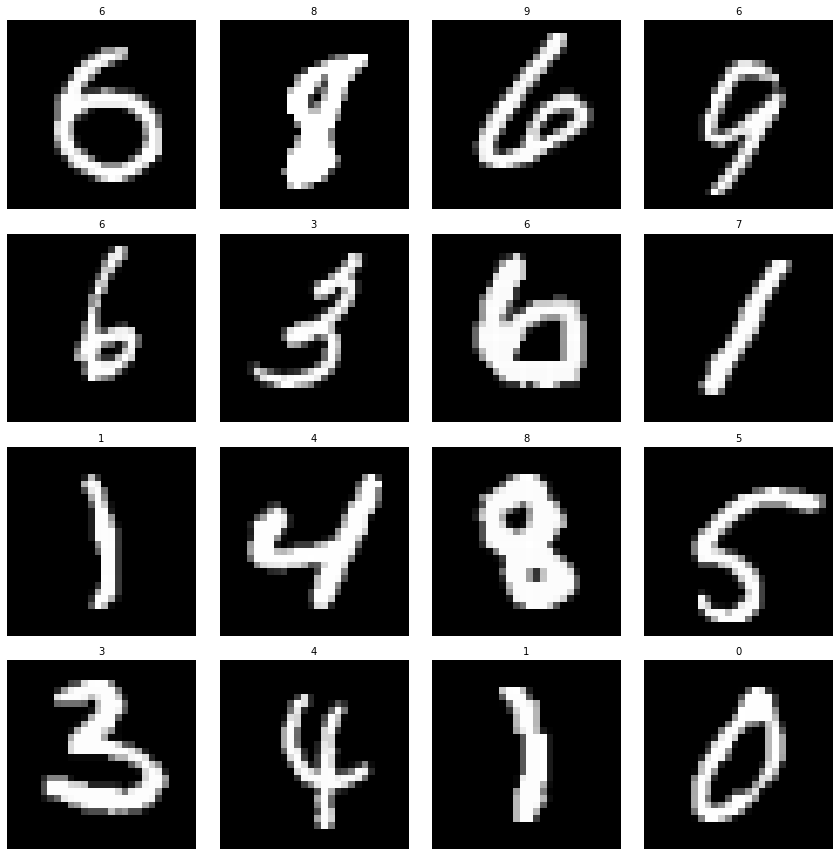

In [100]:
# Assuming mnist_trainloader, ewc_influences are defined
plot_images_with_highest_influences(mnist_trainloader_AN, ewc_influences_AN)

In [86]:
def plot_incorrect_labels_fixed(trainloader, influences, incorrect_labels_indices, algo_names, num_runs=1):
    """
    Plot the relationship between the fraction of incorrect labels fixed and the fraction of data points inspected for multiple algorithms.

    Args:
        trainloader (DataLoader): DataLoader for the training dataset.
        influences (list of lists): List of lists containing influences of different algorithms.
        incorrect_labels_indices (list or set): List or set containing indices of data points with incorrect labels.
        algo_names (list): List containing names of different algorithms for the legend.
        num_runs (int, optional): Number of runs for computing mean and standard deviation. Defaults to 5.
    """
    fractions_inspected = np.arange(0.2, 1.1, 0.2)
    results = {name: [] for name in algo_names}

    for run in range(num_runs):
        for algo_idx, algo_influences in enumerate(influences):
            identified_causes = []
            fixed_incorrect_labels = []

            sorted_indices = np.argsort(algo_influences)

            for fraction in fractions_inspected:
                num_points_to_inspect = int(fraction * len(trainloader))
                top_points = sorted_indices[:num_points_to_inspect]
                num_matched = sum(1 for idx in top_points if idx in incorrect_labels_indices)

                # Create a subset of corrected data by removing top_points
                corrected_data_subset = [(inputs, labels) for idx, (inputs, labels) in enumerate(trainloader) if idx not in top_points]

                # Fine-tune theta on corrected data subset
                theta= torch.cat([param.view(-1) for param in model.parameters()])
                theta_MLE, _ = fine_tune_theta_on_corrected_data(model=model, theta=theta, data_loader=corrected_data_subset, num_epochs=10, lr=0.01)
                
                # Evaluate model with updated theta on failure set
                model_MLE = create_model_with_theta(theta_MLE)
                failure_predictions = evaluate_model(model_MLE, failure_loader)

                # Calculate accuracy on failure set
                accuracy_on_failure = accuracy_score(failure_true_labels, failure_predictions)

                identified_causes.append(num_points_to_inspect)
                fixed_incorrect_labels.append(accuracy_on_failure)

            results[algo_names[algo_idx]].append((identified_causes, fixed_incorrect_labels))

    plt.figure(figsize=(10, 6))

    for algo_name in algo_names:
        mean_fixed_labels = np.mean([res[1] for res in results[algo_name]], axis=0)
        std_fixed_labels = np.std([res[1] for res in results[algo_name]], axis=0)

        plt.errorbar(fractions_inspected, mean_fixed_labels, yerr=std_fixed_labels, fmt='-o', label=algo_name)

    plt.xlabel('Fraction of Data Points Inspected')
    plt.ylabel('Accuracy on Failure Set')
    plt.title('Accuracy on Failure Set vs. Fraction of Data Points Inspected')
    plt.legend()
    plt.grid(True)
    plt.show()


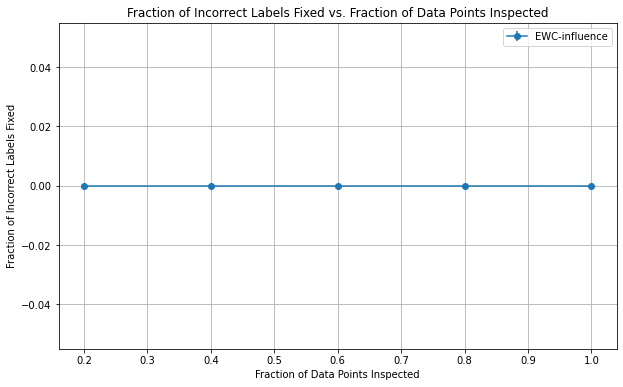

In [87]:
influences= [EWC_influence]
plot_incorrect_labels_fixed(mnist_trainloader_AN, influences, noised_mnist_dataset.noisy_indices, ["EWC-influence"])